In [1]:
import numpy as np
import matplotlib.pyplot as plt
from inspect import signature
from itertools import product
from functools import reduce
from collections import Counter
import time

def get_ddt(sbox):
    """
    Returns the Difference Distribution Table (DDT) for `sbox`
    """
    l = len(sbox)
    ddt = np.zeros((l,l), dtype=int)
    for i,x in enumerate(sbox):
        for j,y in enumerate(sbox):
            ddt[i^^j][x^^y] += 1
    return ddt

def tobits(x:int, nbits:int): 
    """
    Unpacks `x` into a list of `nbits` bits in little endian
    """
    return [*map(int, format(x, "0%db"%nbits)[::-1])]

def frombits(bits):
    """
    Packs `b`, a list of bits into an integer in little endian
    """
    return sum(b*(1<<i) for i,b in enumerate(bits))

def simplify_binary_hrep(space, hrep):
    
    """
    Computes a small subset of inequalities from `hrep`
    which integral points in [0,1]^n is exactly `space`
    """

    npts_space = len(space)
    dim = len(space[0])
    all_eq = [*hrep]
    new_hrep = []
    all_pts = set(product([0,1], repeat=dim)) - set(space)
    eq_pts = [set(pts for pts in all_pts if not hrep_to_ineq([l], pts)[0]) for l in all_eq]
    while True:
        npts = [len(i) for i in eq_pts]
        midx = npts.index(max(npts))
        if npts[midx] == 0: break
        new_hrep.append(all_eq.pop(midx))
        pts = eq_pts.pop(midx)
        eq_pts = [i - pts for i in eq_pts]
    return (*new_hrep,)

def get_boolexpr_hrep(boolfunc, optimize=True):
    """
    Get H-Representation of points representing
    (a0,a1,...,an, boolfunc(a0,a1,...,an))
    
    boolfunc is a boolean function of n-args with a boolean output
    """
    nargs = len(signature(boolfunc).parameters)
    space = []
    for nb in product([0,1], repeat=nargs):
        space.append((*nb, boolfunc(*nb)))
        
    p = Polyhedron(vertices=space)
    hrep = p.Hrepresentation()
    if not optimize:
        return hrep
    return simplify_binary_hrep(space, hrep)

def get_ddt_hrep(ddt, threshold:int=0, optimize=True):
    """
    Get H-Representation of possible differentials of a ddt,
    consisting of points 
    (i0,i1,...,in , o0,o1,...,on) where
    (i0,i1,...,in) is the input differential and
    (o0,o1,...,on) is the output differential
    
    `threshold` (default 0) determines how probable a differential has to be
    to be included. A differential will not be included if
    ddt[x,y] <= threshold.
    """
    l = len(ddt[0])
    lb = int(l).bit_length()-1
    assert l == 1<<lb, "Size of SBOX isn't a power of two!"
    space = []
    for x in range(l):
        for y in range(l):
            if ddt[x,y] <= threshold: continue
            xb = tobits(x, lb)
            yb = tobits(y, lb)
            space.append((*xb, *yb))
    
    p = Polyhedron(vertices=space)
    hrep = p.Hrepresentation()
    if not optimize:
        return hrep
    return simplify_binary_hrep(space, hrep)

def hrep_to_ineq(hrep, args):
    """
    Returns a list of inequality constraints given
    `hrep` -> a H-representation and
    `args` -> a list of MILP vars
    """
    assert len(args) == len(hrep[0]) - 1, \
        "Number of arguments does not match dimensionality of `hrep`"
    return [
        sum(a*c for c,a in zip([*l][1:], args)) + l.b() >= 0 
        for l in hrep
    ]

def perm(perm, args):
    """
    Permutates `args` based on the permutation table `perm`
    """
    assert len(args) == len(perm)
    return [args[perm[i]] for i in range(len(args))]

def constraint_exclude(args, vals):
    #return sum(a if v==0 else 1-a for a,v in zip(args,vals)) >= 1
    return sum(a if v==0 else -a for a,v in zip(args,vals)) >= 1 - sum(vals)

In [2]:
class VarGen:
    
    """
    Wrapper class over `solver.new_variable`
    to provide the `gen` method
    """
    
    def __init__(self, solver:MixedIntegerLinearProgram):
        self.vargen = solver.new_variable(binary=True)
        
    def __getitem__(self, idx):
        """Get an existing variable at index `idx`"""
        assert idx < len(self.vargen.keys())
        return self.vargen[idx]
    
    def gen(self):
        """Generates a new variable"""
        return self.vargen[len(self.vargen.keys())]
    
def toblks(arr, blocklen:int):
    
    """
    Splits `arr` into a list of length `blocklen`.
    E.g. toblks([1,2,3,4,5,6,7,8], 4) -> [[1,2,3,4], [5,6,7,8]]
    """
    
    bl = blocklen
    assert len(arr)%bl == 0, "`blocklen` isn't a divisor of `len(arr)`"
    return [arr[bl*i:bl*i+bl] for i in range(len(arr)//bl)]

In [170]:
def print_stats(solver):
    
    print("Active SBOX:", int(solver.get_objective_value()))
    
    print("PT Differentials")
    pt_diff = " ".join(["".join(map(str, map(int, x))) for x in map(solver.get_values, toblks(pt, 4))]).replace("0", ".")
    print(" "*5, pt_diff)

    print("SBOX I/O:")
    for i,o in zip(toblks(sbox_ins, 16), toblks(sbox_outs, 16)):
        print(" IN :", " ".join(["".join(map(str, map(int, x))) for x in map(solver.get_values, i)]).replace("0", "."))
        print(" OUT:", " ".join(["".join(map(str, map(int, x))) for x in map(solver.get_values, o)]).replace("0", "."))

    print("CT Differentials")
    ct_diff = " ".join(["".join(map(str, map(int, x))) for x in map(solver.get_values, toblks(ct, 4))]).replace("0", ".")
    print(" "*5, ct_diff)

    probabiliy = get_probability(solver)
    print()
    print("Probability of differential:", probabiliy)
    print(" - One in", int(round(1/probabiliy)))
    return int(round(1/probabiliy))

def get_probability(solver):
    sbox_io = [
        (
            [*map(int, map(frombits, solver.get_values(i)))], 
            [*map(int, map(frombits, solver.get_values(o)))]
        )
        for i,o in zip(toblks(sbox_ins, 4), toblks(sbox_outs, 4))
    ]
    print(set([(di,do) for i,o in sbox_io for di,do in zip(i,o)]))
    # Compute probability of all differentials occuring
    mul = lambda arr: reduce(lambda x,y: x*y, arr)
    return mul(
        mul(ddt[di][do]/sum(ddt[di]) for di,do in zip(i,o))
        for i,o in sbox_io
    )

In [171]:
import random

#SBOX = [0xc, 0x5, 0x6, 0xb, 0x9, 0x0, 0xa, 0xd, 0x3, 0xe, 0xf, 0x8, 0x4, 0x7, 0x1, 0x2]
##PERM = [0, 4, 8, 12, 1, 5, 9, 13, 2, 6, 10, 14, 3, 7, 11, 15]
PERM = [0, 16, 32, 48, 1, 17, 33, 49, 2, 18, 34, 50, 3, 19, 35, 51,
        4, 20, 36, 52, 5, 21, 37, 53, 6, 22, 38, 54, 7, 23, 39, 55,
        8, 24, 40, 56, 9, 25, 41, 57, 10, 26, 42, 58, 11, 27, 43, 59,
        12, 28, 44, 60, 13, 29, 45, 61, 14, 30, 46, 62, 15, 31, 47, 63]

#random.shuffle(PERM := [*range(64)])
#random.shuffle(SBOX := [*range(16)])

In [172]:
import random

def swap(a,x,y):
    a[x] ^^= a[y]
    a[y] ^^= a[x]
    a[x] ^^= a[y]

random.seed(1)
PERM = [0, 16, 32, 48, 1, 17, 33, 49, 2, 18, 34, 50, 3, 19, 35, 51,
        4, 20, 36, 52, 5, 21, 37, 53, 6, 22, 38, 54, 7, 23, 39, 55,
        8, 24, 40, 56, 9, 25, 41, 57, 10, 26, 42, 58, 11, 27, 43, 59,
        12, 28, 44, 60, 13, 29, 45, 61, 14, 30, 46, 62, 15, 31, 47, 63]

#random.shuffle(SBOX := [*range(16)])
SBOX = [(3 + 7*j)%16 for j in range(16)]
len(set(SBOX))
swap(SBOX, 5, 2)
swap(SBOX, 14, 10)

In [173]:
# Precompiled

opt = True
threshold = 4

# SBOX H-rep
ddt = get_ddt(SBOX)
print("Getting SBOX href...")
hrep_sbox = get_ddt_hrep(ddt, threshold=threshold, optimize=opt)

# H-rep for the boolean function `a or b or c or d -> e`
print("Getting `a or b or c or d -> e` href...")
hrep_isactive = get_boolexpr_hrep(lambda a,b,c,d: a or b or c or d, optimize=opt)

Getting SBOX href...
Getting `a or b or c or d -> e` href...


In [174]:
ddt_thres = ddt > threshold
ddt_hrep = np.array([[True if all(hrep_to_ineq(hrep_sbox, (*tobits(y,4), *tobits(x,4)))) else False for x in range(16)] for y in range(16)])

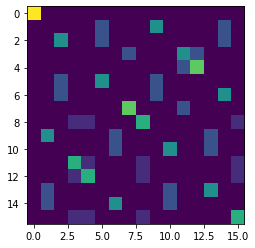

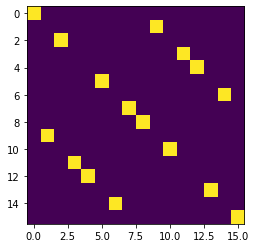

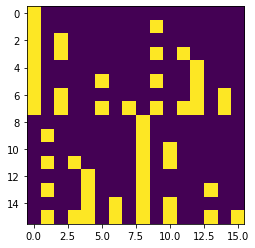

In [175]:
plt.imshow(ddt)
plt.show()
plt.imshow(ddt_thres)
plt.show()
plt.imshow(ddt_hrep)
plt.show()

In [191]:
# x0 = (x - i0) + (x - i0)

In [197]:
d = dict([(x,y) for x in range(16) for y in range(16) if ddt_thres[x,y] != 0])
sbox = [d[i] for i in range(16)]

[0, 9, 2, 11, 12, 5, 14, 7, 8, 1, 10, 3, 4, 13, 6, 15]

In [176]:
t = time.time()

NROUNDS = 12

solver = MixedIntegerLinearProgram(maximization=False, solver="Gurobi")
vargen = VarGen(solver)

#
# Define possible differentials
#

# Create var for plaintext
pt = [vargen.gen() for i in range(16*4)]

ct = pt[:]
sbox_ins = [] # Saves all vars that corresponds to an SBOX input
sbox_outs = [] # Saves all vars that corresponds to an SBOX output
for r in range(NROUNDS):
    
    # Save vars for sbox input
    sbox_ins.extend(toblks(ct, 4))
    
    # Create vars for sbox output
    sbox_out = [vargen.gen() for i in range(16*4)]
    # Save vars for sbox output
    sbox_outs.extend(toblks(sbox_out, 4))
    
    # Constraint ct and sbox_out
    for ctblk,oblk in zip(toblks(ct, 4), toblks(sbox_out, 4)):
        for c in hrep_to_ineq(hrep_sbox, ctblk + oblk):
            solver.add_constraint(c)
    
    # permutate sbox
    ct = perm(PERM, sbox_out)

# Assert non-zero differential
solver.add_constraint(sum(pt) >= 1)
#solver.add_constraint(sum(ct[:4]) >= 1)

#
# Define objective function
#

# Variables to store if an sbox is active
var_isactive = [vargen.gen() for _ in range(len(sbox_ins))]

# Constraint `var_isactive` to correspond to if an sbox is active
for sbox_in, is_active in zip(sbox_ins, var_isactive):
    for c in hrep_to_ineq(hrep_isactive, sbox_in + [is_active]):
        solver.add_constraint(c)
        
# Enforce PT differential = CT differential
for p,c in zip(pt, ct):
    solver.add_constraint(p == c)

# Add matsuri constraints
for i in range(1, NROUNDS):
    solver.add_constraint(sum(var_isactive[:i*16]) <= 2*i)
    solver.add_constraint(sum(var_isactive[-i*16:]) <= 2*i)

# Set objective to be the number of acti2ve sboxes
objective = sum(var_isactive)
solver.set_objective(objective)

print("Number of constraints:", solver.number_of_constraints())
solver.solve()
print_stats(solver)
    
print("Time Taken:", time.time() - t)

Number of constraints: 3159
Active SBOX: 12
PT Differentials
      .... .... .... .... .... .... .... .... .... .... .... .... .... .1.. .... ....
SBOX I/O:
 IN : .... .... .... .... .... .... .... .... .... .... .... .... .... .1.. .... ....
 OUT: .... .... .... .... .... .... .... .... .... .... .... .... .... .1.. .... ....
 IN : .... .... .... .... .... ...1 .... .... .... .... .... .... .... .... .... ....
 OUT: .... .... .... .... .... ...1 .... .... .... .... .... .... .... .... .... ....
 IN : .... .... .... .... .... .... .... .1.. .... .... .... .... .... .... .... ....
 OUT: .... .... .... .... .... .... .... .1.. .... .... .... .... .... .... .... ....
 IN : .... .... .... .... .... .... .... .... .... .... .... .... .... .1.. .... ....
 OUT: .... .... .... .... .... .... .... .... .... .... .... .... .... .1.. .... ....
 IN : .... .... .... .... .... ...1 .... .... .... .... .... .... .... .... .... ....
 OUT: .... .... .... .... .... ...1 .... .... .... .... .... .... ...

In [177]:
t = time.time()

NROUNDS = 12
FULL_ATTACK = True
PTCTDIFF = []
LOG = open("log-ddt-12rounds-min", "w")

solver = MixedIntegerLinearProgram(maximization=False, solver="Gurobi")
vargen = VarGen(solver)

#
# Define possible differentials
#

# Create var for plaintext
pt = [vargen.gen() for i in range(16*4)]

ct = pt[:]
sbox_ins = [] # Saves all vars that corresponds to an SBOX input
sbox_outs = [] # Saves all vars that corresponds to an SBOX output
for r in range(NROUNDS):
    
    # Save vars for sbox input
    sbox_ins.extend(toblks(ct, 4))
    
    # Create vars for sbox output
    sbox_out = [vargen.gen() for i in range(16*4)]
    # Save vars for sbox output
    sbox_outs.extend(toblks(sbox_out, 4))
    
    # Constraint ct and sbox_out
    for ctblk,oblk in zip(toblks(ct, 4), toblks(sbox_out, 4)):
        for c in hrep_to_ineq(hrep_sbox, ctblk + oblk):
            solver.add_constraint(c)
    
    # permutate sbox
    ct = perm(PERM, sbox_out)

# Assert non-zero differential
solver.add_constraint(sum(pt) >= 1)

#
# Define objective function
#

# Variables to store if an sbox is active
var_isactive = [vargen.gen() for _ in range(len(sbox_ins))]

# Constraint `var_isactive` to correspond to if an sbox is active
for sbox_in, is_active in zip(sbox_ins, var_isactive):
    for c in hrep_to_ineq(hrep_isactive, sbox_in + [is_active]):
        solver.add_constraint(c)
        
# Enforce PT differential = CT differential
#for p,c in zip(pt, ct):
#    solver.add_constraint(p == c)
    
# Add matsuri constraints
for i in range(1, NROUNDS):
    solver.add_constraint(sum(var_isactive[:i*16]) <= 2*i)
    solver.add_constraint(sum(var_isactive[-i*16:]) <= 2*i)
        
if FULL_ATTACK:
    # vars to represent an active ct differential
    var_ctdiff = [vargen.gen() for _ in range(16)]
    for ctblk, ctdiff in zip(toblks(ct, 4), var_ctdiff):
        for c in hrep_to_ineq(hrep_isactive, ctblk + [ctdiff]):
            solver.add_constraint(c)
            

# Set objective to be the number of active sboxes
objective = sum(var_isactive)
solver.set_objective(objective)

print("Number of constraints:", solver.number_of_constraints())

if FULL_ATTACK:
    ct_recovered = set()
    solver.add_constraint(sum(var_ctdiff) >= 1)
    while len(ct_recovered) < 16:

        solver.solve()
        
        ct_recovered = ct_recovered.union(
            set(i for i,b in enumerate(solver.get_values(var_ctdiff)) if int(b))
        )
        print("-"*30)
        print("Recovered:", ct_recovered)
        onein = print_stats(solver)
        PTCTDIFF.append(
            (onein, [*map(int, solver.get_values(pt))], [*map(int, solver.get_values(ct))])
        )
        LOG.write(str(PTCTDIFF[-1]) + "\n")
        LOG.write("Recovered: " + str(ct_recovered) + "\n")
        LOG.flush()
        
        # Replace the last constraints
        solver.remove_constraint(solver.number_of_constraints()-1)
        solver.add_constraint(
            sum(var_ctdiff) - sum(var_ctdiff[i] for i in ct_recovered) >= 1
        )
        
else:
    solver.solve()
    print_stats(solver)
    
print("Time Taken:", time.time() - t)

Number of constraints: 3175
------------------------------
Recovered: {13}
Active SBOX: 12
PT Differentials
      .... .... .... .... .... .... .... .... .... .... .... .... .... 111. .... ....
SBOX I/O:
 IN : .... .... .... .... .... .... .... .... .... .... .... .... .... 111. .... ....
 OUT: .... .... .... .... .... .... .... .... .... .... .... .... .... .1.. .... ....
 IN : .... .... .... .... .... ...1 .... .... .... .... .... .... .... .... .... ....
 OUT: .... .... .... .... .... ...1 .... .... .... .... .... .... .... .... .... ....
 IN : .... .... .... .... .... .... .... .1.. .... .... .... .... .... .... .... ....
 OUT: .... .... .... .... .... .... .... .1.. .... .... .... .... .... .... .... ....
 IN : .... .... .... .... .... .... .... .... .... .... .... .... .... .1.. .... ....
 OUT: .... .... .... .... .... .... .... .... .... .... .... .... .... .1.. .... ....
 IN : .... .... .... .... .... ...1 .... .... .... .... .... .... .... .... .... ....
 OUT: .... .... .... .

/tmp/ipykernel_8757/2860128765.py:21: RuntimeWarning: divide by zero encountered in double_scalars
  print(" - One in", int(round(Integer(1)/probabiliy)))


OverflowError: cannot convert float infinity to integer

In [ ]:
t = time.time()

NROUNDS = 12
FULL_ATTACK = True
PTCTDIFF = []
LOG = open("log-ddt-??rounds", "w")

solver = MixedIntegerLinearProgram(maximization=False, solver="Gurobi")
vargen = VarGen(solver)

#
# Define possible differentials
#

# Create var for plaintext
pt = [vargen.gen() for i in range(16*4)]

ct = pt[:]
sbox_ins = [] # Saves all vars that corresponds to an SBOX input
sbox_outs = [] # Saves all vars that corresponds to an SBOX output
for r in range(NROUNDS):
    
    # Save vars for sbox input
    sbox_ins.extend(toblks(ct, 4))
    
    # Create vars for sbox output
    sbox_out = [vargen.gen() for i in range(16*4)]
    # Save vars for sbox output
    sbox_outs.extend(toblks(sbox_out, 4))
    
    # Constraint ct and sbox_out
    for ctblk,oblk in zip(toblks(ct, 4), toblks(sbox_out, 4)):
        for c in hrep_to_ineq(hrep_sbox, ctblk + oblk):
            solver.add_constraint(c)
    
    # permutate sbox
    ct = perm(PERM, sbox_out)

# Assert non-zero differential
solver.add_constraint(sum(pt) >= 1)

#
# Define objective function
#

# Variables to store if an sbox is active
var_isactive = [vargen.gen() for _ in range(len(sbox_ins))]

# Constraint `var_isactive` to correspond to if an sbox is active
for sbox_in, is_active in zip(sbox_ins, var_isactive):
    for c in hrep_to_ineq(hrep_isactive, sbox_in + [is_active]):
        solver.add_constraint(c)
        
# Enforce PT differential = CT differential
#for p,c in zip(pt, ct):
#    solver.add_constraint(p == c)
    
# Add matsuri constraints
for i in range(1, NROUNDS):
    solver.add_constraint(sum(var_isactive[:i*16]) <= 2*i)
    solver.add_constraint(sum(var_isactive[-i*16:]) <= 2*i)
        
if FULL_ATTACK:
    # vars to represent an active ct differential
    var_ctdiff = [vargen.gen() for _ in range(16)]
    for ctblk, ctdiff in zip(toblks(ct, 4), var_ctdiff):
        for c in hrep_to_ineq(hrep_isactive, ctblk + [ctdiff]):
            solver.add_constraint(c)
            

# Set objective to be the number of active sboxes
objective = sum(var_isactive)
solver.set_objective(objective)

print("Number of constraints:", solver.number_of_constraints())

if FULL_ATTACK:
    ct_recovered = set()
    solver.add_constraint(sum(var_ctdiff) >= 1)
    while len(ct_recovered) < 16:

        solver.solve()
        
        ct_recovered = ct_recovered.union(
            set(i for i,b in enumerate(solver.get_values(var_ctdiff)) if int(b))
        )
        print("-"*30)
        print("Recovered:", ct_recovered)
        onein = print_stats(solver)
        PTCTDIFF.append(
            (onein, [*map(int, solver.get_values(pt))], [*map(int, solver.get_values(ct))])
        )
        LOG.write(str(PTCTDIFF[-1]) + "\n")
        LOG.write("Recovered: " + str(ct_recovered) + "\n")
        LOG.flush()
        
        # Replace the last constraints
        solver.remove_constraint(solver.number_of_constraints()-1)
        solver.add_constraint(
            sum(var_ctdiff) - sum(var_ctdiff[i] for i in ct_recovered) >= 1
        )
        
else:
    solver.solve()
    print_stats(solver)
    
print("Time Taken:", time.time() - t)

In [ ]:
print(PTCTDIFF)

In [8]:
ddt

array([[16,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  4,  0,  0,  0,  8,  0,  0,  0,  0,  4,  0],
       [ 0,  0,  8,  0,  0,  4,  0,  0,  0,  0,  0,  0,  0,  0,  4,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  4,  0,  0,  0,  8,  4,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  4, 12,  0,  0,  0],
       [ 0,  0,  4,  0,  0,  8,  0,  0,  0,  4,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  4,  0,  0,  0,  0,  0,  0,  4,  0,  0,  0,  0,  8,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 12,  0,  0,  0,  4,  0,  0,  0,  0],
       [ 0,  0,  0,  2,  2,  0,  0,  0, 10,  0,  0,  0,  0,  0,  0,  2],
       [ 0,  8,  0,  0,  0,  0,  4,  0,  0,  0,  0,  0,  0,  4,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  4,  0,  0,  0,  8,  0,  0,  4,  0,  0],
       [ 0,  0,  0, 10,  2,  0,  0,  0,  2,  0,  0,  0,  0,  0,  0,  2],
       [ 0,  0,  0,  2, 10,  0,  0,  0,  2,  0,  0,  0,  0,  0,  0,  2],
       [ 0,  4,  0,  0,  0,  0,  0,  0,  0,  0,  4,

In [7]:
t = time.time()

NROUNDS = 5

solver = MixedIntegerLinearProgram(maximization=False, solver="Gurobi")
vargen = VarGen(solver)

#
# Define possible differentials
#

# Create var for plaintext
pt = [vargen.gen() for i in range(16*4)]

ct = pt[:]
sbox_ins = [] # Saves all vars that corresponds to an SBOX input
sbox_outs = [] # Saves all vars that corresponds to an SBOX output
for r in range(NROUNDS):
    
    # Save vars for sbox input
    sbox_ins.extend(toblks(ct, 4))
    
    # Create vars for sbox output
    sbox_out = [vargen.gen() for i in range(16*4)]
    # Save vars for sbox output
    sbox_outs.extend(toblks(sbox_out, 4))
    
    # Constraint ct and sbox_out
    for ctblk,oblk in zip(toblks(ct, 4), toblks(sbox_out, 4)):
        for c in hrep_to_ineq(hrep_sbox, ctblk + oblk):
            solver.add_constraint(c)
    
    # permutate sbox
    ct = perm(PERM, sbox_out)

# Assert non-zero differential
solver.add_constraint(sum(pt) >= 1)

#
# Define objective function
#

# Variables to store if an sbox is active
var_isactive = [vargen.gen() for _ in range(len(sbox_ins))]

# Constraint `var_isactive` to correspond to if an sbox is active
for sbox_in, is_active in zip(sbox_ins, var_isactive):
    for c in hrep_to_ineq(hrep_isactive, sbox_in + [is_active]):
        solver.add_constraint(c)
        
#for x,y in zip(pt,ct):
#    solver.add_constraint(x==y)

# Set objective to be the number of active sboxes
objective = sum(var_isactive)
solver.set_objective(objective)

print("Number of constraints:", solver.number_of_constraints())

msbox = 0
while True:
    _ = solver.solve()
    if msbox == 0: msbox = _
    if _ > msbox: break
    print_stats(solver)
    solver.add_constraint(constraint_exclude(pt+ct, solver.get_values(pt+ct)))
    print()
    
print("Time Taken:", time.time() - t)

Number of constraints: 1041
Active SBOX: 6
PT Differentials
      .... ..11 .... .... .... .... .... .... .... .... .... .... .... .... .... ....
SBOX I/O:
 IN : .... ..11 .... .... .... .... .... .... .... .... .... .... .... .... .... ....
 OUT: .... ..1. .... .... .... .... .... .... .... .... .... .... .... .... .... ....
 IN : .... .... .... .... .... .... .... .... 1... .... .... .... .... .... .... ....
 OUT: .... .... .... .... .... .... .... .... 11.. .... .... .... .... .... .... ....
 IN : .... .... 1..1 .... .... .... .... .... .... .... .... .... .... .... .... ....
 OUT: .... .... .1.. .... .... .... .... .... .... .... .... .... .... .... .... ....
 IN : .... .... .... .... .... .1.. .... .... .... .... .... .... .... .... .... ....
 OUT: .... .... .... .... .... 1..1 .... .... .... .... .... .... .... .... .... ....
 IN : .... .... .... .... .... .... .... .... .... ..1. .... .... ..1. .... .... ....
 OUT: .... .... .... .... .... .... .... .... .... 111. .... .... 111.

In [432]:
import secrets

def concrete_encrypt(pt, kr):
    assert len(kr) == NROUNDS
    for k in kr:
        pt = [x^^y for x,y in zip(k,pt)]
        pt = [SBOX[x] for x in pt]
        pt = [b for x in pt for b in tobits(x, 4)]
        pt = perm(PERM, pt)
        pt = [frombits(x) for x in toblks(pt, 4)]
    return pt
    
kr = [
    [secrets.randbits(4) for _ in range(16)]
    for _ in range(NROUNDS)
]

In [354]:
import secrets

def to_nibbles(x:int, nnibs:int=16):
    return [(x>>(4*i)) & 0xf for i in range(nnibs)]

def from_nibbles(nibs):
    return sum(n<<(4*i) for i,n in enumerate(nibs))

def get_pairs(pt_diff, n):
    pairs = []
    for _ in range(n):
        p0 = secrets.randbits(4*16)
        p1 = p0
        for d in pt_diff:
            p1 ^^= 1<<d
        pairs.append(
            ((p0,p1), (
                from_nibbles(concrete_encrypt(to_nibbles(p0), kr)), 
                from_nibbles(concrete_encrypt(to_nibbles(p1), kr))))
        )
    return pairs

pt_diff_idx = [i for i,b in enumerate(pt_diff.replace(" ", "")) if b=="1"]
ptct_pairs = get_pairs(pt_diff_idx, 100000)
ct_diff_em = [c0^^c1 for (_,_),(c0,c1) in ptct_pairs]
ct_diff_freq = Counter(ct_diff_em)
sorted(ct_diff_freq.items(), key=lambda x: -x[1])[:10]

[(17596481011985, 433),
 (70385924064260, 432),
 (1172526075905, 419),
 (70385924046916, 415),
 (1172526071825, 412),
 (17596481011729, 408),
 (74783970558020, 404),
 (292057777220, 398),
 (4690104303620, 398),
 (74783970574340, 398)]

In [358]:
c = [int(i.replace(".", "0")[::-1], 2) for i in ct_diff.split(" ")]
cn = from_nibbles(c)
ct_diff_freq[cn], cn

(374, 70385924047940)

In [461]:
def get_ddt_hrep_0(ddt, threshold:int=0):
    """
    Get H-Representation of possible differentials of a ddt,
    consisting of points 
    (i0,i1,...,in , o0,o1,...,on) where
    (i0,i1,...,in) is the input differential and
    (o0,o1,...,on) is the output differential
    
    `threshold` (default 0) determines how probable a differential has to be
    to be included. A differential will not be included if
    ddt[x,y] <= threshold.
    """
    l = len(ddt[0])
    lb = int(l).bit_length()-1
    assert l == 1<<lb, "Size of SBOX isn't a power of two!"
    space = []
    for x in range(l):
        for y in range(l):
            if ddt[x,y] <= threshold: continue
            xb = tobits(x, lb)
            yb = tobits(y, lb)
            space.append((*xb, *yb))
    
    p = Polyhedron(vertices=space)
    return p, p.Hrepresentation()

ddt = get_ddt(SBOX)
poly, hrep = get_ddt_hrep_0(ddt, threshold=2)

In [458]:
Bn = polytopes.hypercube(8, intervals='zero_one')

[An inequality (9, 2, -7, -5, 8, 3, 4, -6) x + 0 >= 0,
 An inequality (-1, -6, 4, -2, -3, -4, 3, 1) x + 8 >= 0,
 An inequality (2, 4, -1, 5, 4, -6, 0, -1) x + 0 >= 0,
 An inequality (-5, -3, 4, 6, 4, 9, -1, 2) x + 0 >= 0,
 An inequality (-3, 4, -2, -5, -1, 3, 1, -3) x + 7 >= 0,
 An inequality (3, -1, -1, 0, -1, 5, 2, -2) x + 0 >= 0,
 An inequality (0, -1, -1, -1, -1, -2, -1, 3) x + 4 >= 0,
 An inequality (2, 1, 1, -1, 1, -2, -1, 3) x + 0 >= 0,
 An inequality (-3, -1, -1, 0, -4, 2, -4, 2) x + 9 >= 0,
 An inequality (-3, 1, 1, 5, 1, 4, -2, 4) x + 0 >= 0]